# Disease Classification

## Import all the Dependencies

In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import winsound
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

## Set all the Constants

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CHANNELS = 3
EPOCHS = 50

## Function to Convert Grayscale to RGB

In [4]:
def convert_to_rgb(image):
    if image.shape[-1] == 1:  # Check if it's grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    return image

## Initializing, Exploring & Partioning the Dataset

### Reading and Partitioning the Dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"./../MRL_DataSet/Test_dataset",
shuffle = True,
image_size = (IMAGE_SIZE, IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 17026 files belonging to 2 classes.


### Checking the Available Classes

In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

2 ['Close-Eyes', 'Open-Eyes']


### Apply the conversion function to all images

In [7]:
dataset = dataset.map(lambda x, y: (tf.map_fn(convert_to_rgb, x), y))

### Function to Split Dataset
- Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Displaying Some Sample Images

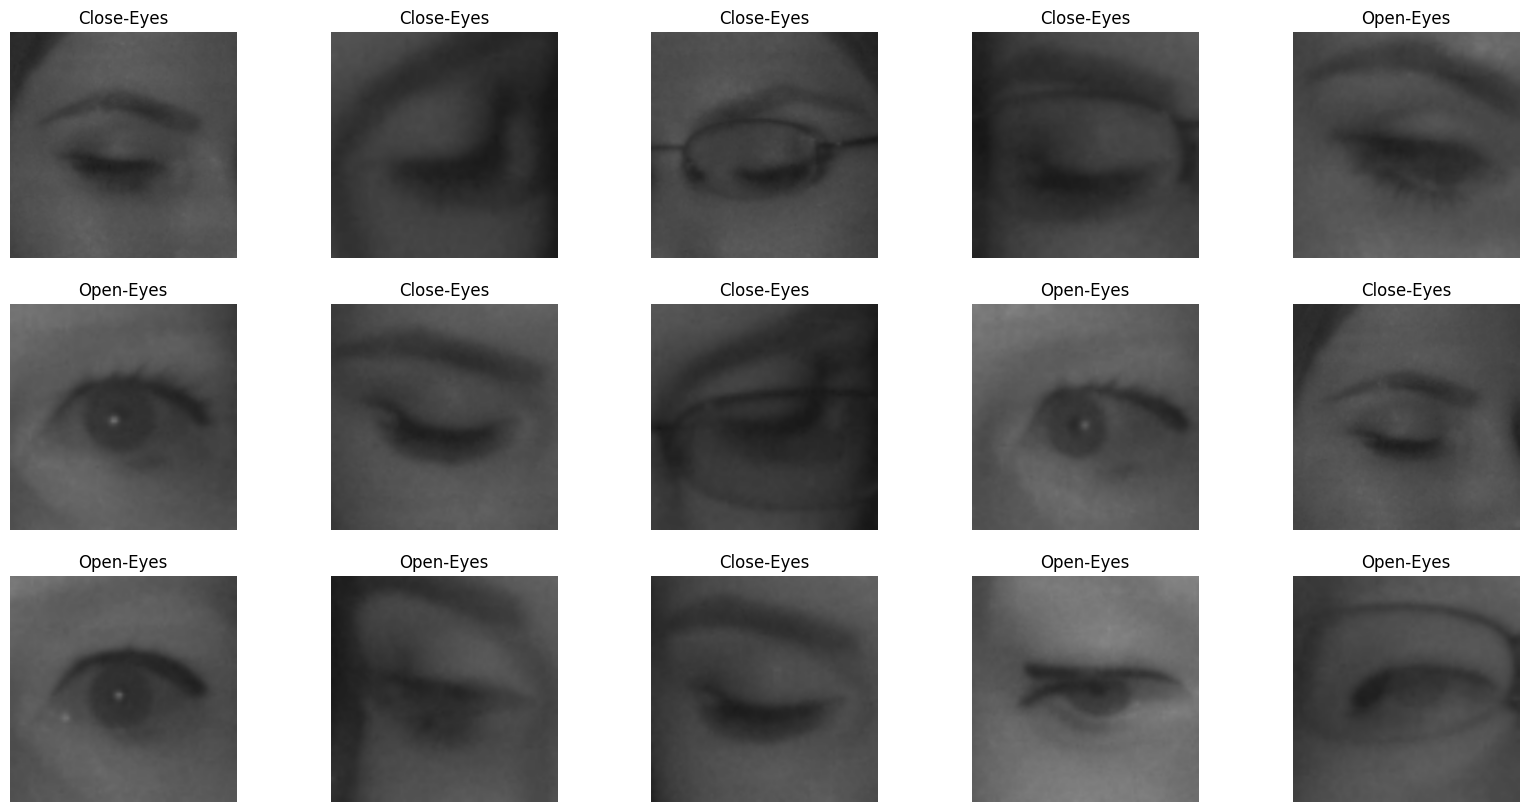

In [9]:
plt.figure(figsize=(20, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype( "uint8" ))
        plt.title( class_names[ label_batch[i] ] )
        plt.axis( "off")

### Checking Batch Size

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

# def preprocess_image(image, label):
#     image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize if needed
#     image = image / 255.0  # Normalize
#     return image, label

# train_ds = train_ds.map(preprocess_image)
# val_ds = val_ds.map(preprocess_image)
# test_ds = test_ds.map(preprocess_image)


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
    # tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomContrast(0.2),
])

### Checking what is the expected dimension order for channel

In [14]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [15]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)


### Model Summary

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                  

### Compiling the Model
We use **adam** Optimizer, **SparseCategoricalCrossentropy** for losses, **accuracy** as a metric

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# CategoricalCrossentropy

### Training the Network

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)
# Solution: Remove batch_size=BATCH_SIZE.

Epoch 1/50
426/426 [==============================] - 120s 239ms/step - loss: 0.3106 - accuracy: 0.8562 - val_loss: 0.1741 - val_accuracy: 0.9351
Epoch 2/50
426/426 [==============================] - 63s 147ms/step - loss: 0.1638 - accuracy: 0.9389 - val_loss: 0.1301 - val_accuracy: 0.9493
Epoch 3/50
426/426 [==============================] - 35s 81ms/step - loss: 0.1332 - accuracy: 0.9516 - val_loss: 0.1101 - val_accuracy: 0.9587
Epoch 4/50
426/426 [==============================] - 34s 81ms/step - loss: 0.1113 - accuracy: 0.9608 - val_loss: 0.0903 - val_accuracy: 0.9646
Epoch 5/50
426/426 [==============================] - 34s 81ms/step - loss: 0.1048 - accuracy: 0.9628 - val_loss: 0.0773 - val_accuracy: 0.9758
Epoch 6/50
426/426 [==============================] - 34s 81ms/step - loss: 0.0931 - accuracy: 0.9664 - val_loss: 0.0628 - val_accuracy: 0.9776
Epoch 7/50
426/426 [==============================] - 34s 81ms/step - loss: 0.0886 - accuracy: 0.9696 - val_loss: 0.0806 - val_accura

### Testing the Model

In [19]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
54/54 [==============================] - 41s 33ms/step - loss: 0.0357 - accuracy: 0.9878
Test Accuracy: 98.78%


### Plotting the Accuracy and Loss Curves

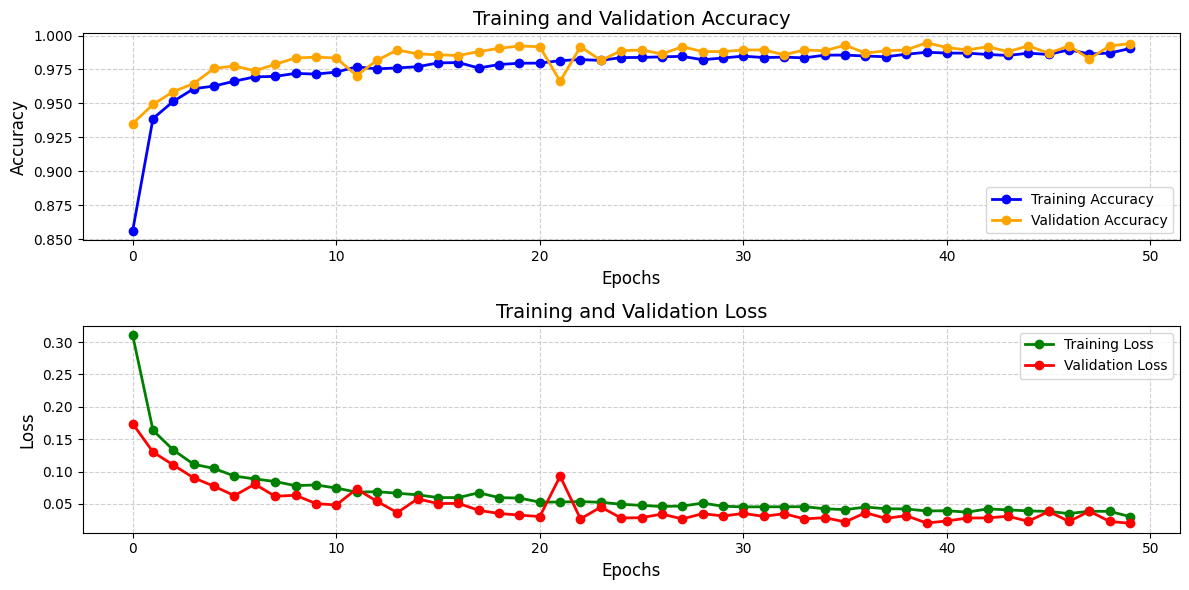

In [20]:
# Define data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Create a figure with improved layout and separate plots for better readability
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, position 1
plt.plot(epochs_range, acc, 'o-', label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10)

# Plot Training and Validation Loss
plt.subplot(2, 1, 2)  # 2 rows, 1 column, position 2
plt.plot(epochs_range, loss, 'o-', label='Training Loss', color='green', linewidth=2)
plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Saving the Model
We append the model to the list of models as a new version

In [30]:
# Ensure the models directory exists
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Get the highest model version number
model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1

# ✅ Save the complete model (architecture + weights)
model.save(f"{models_dir}/MyModel{model_version}.h5")

### Confusion matrix

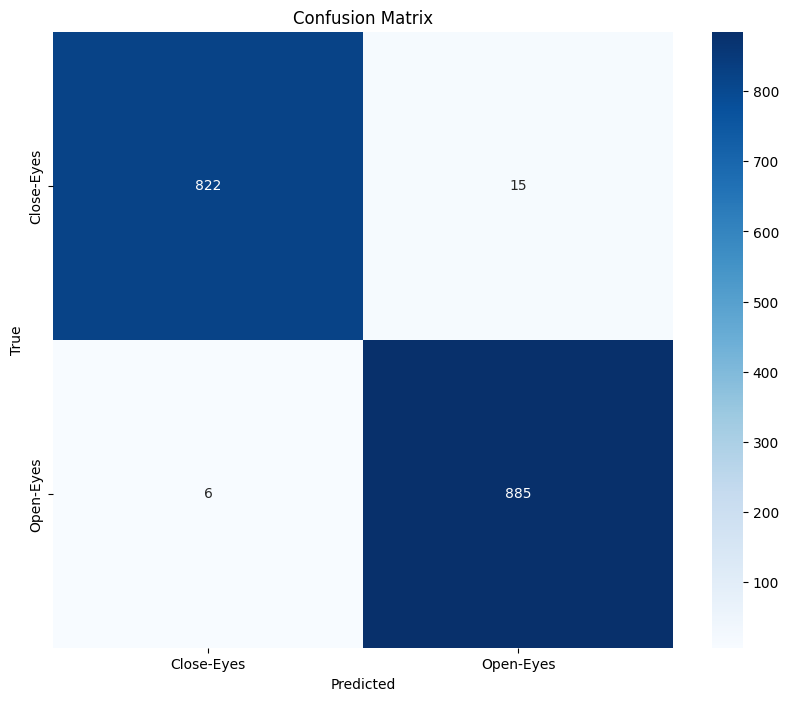

In [22]:
# Get true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_ds:
    true_labels.extend(labels)
    preds = model.predict(images)
    pred_labels.extend(tf.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Function for Inference

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

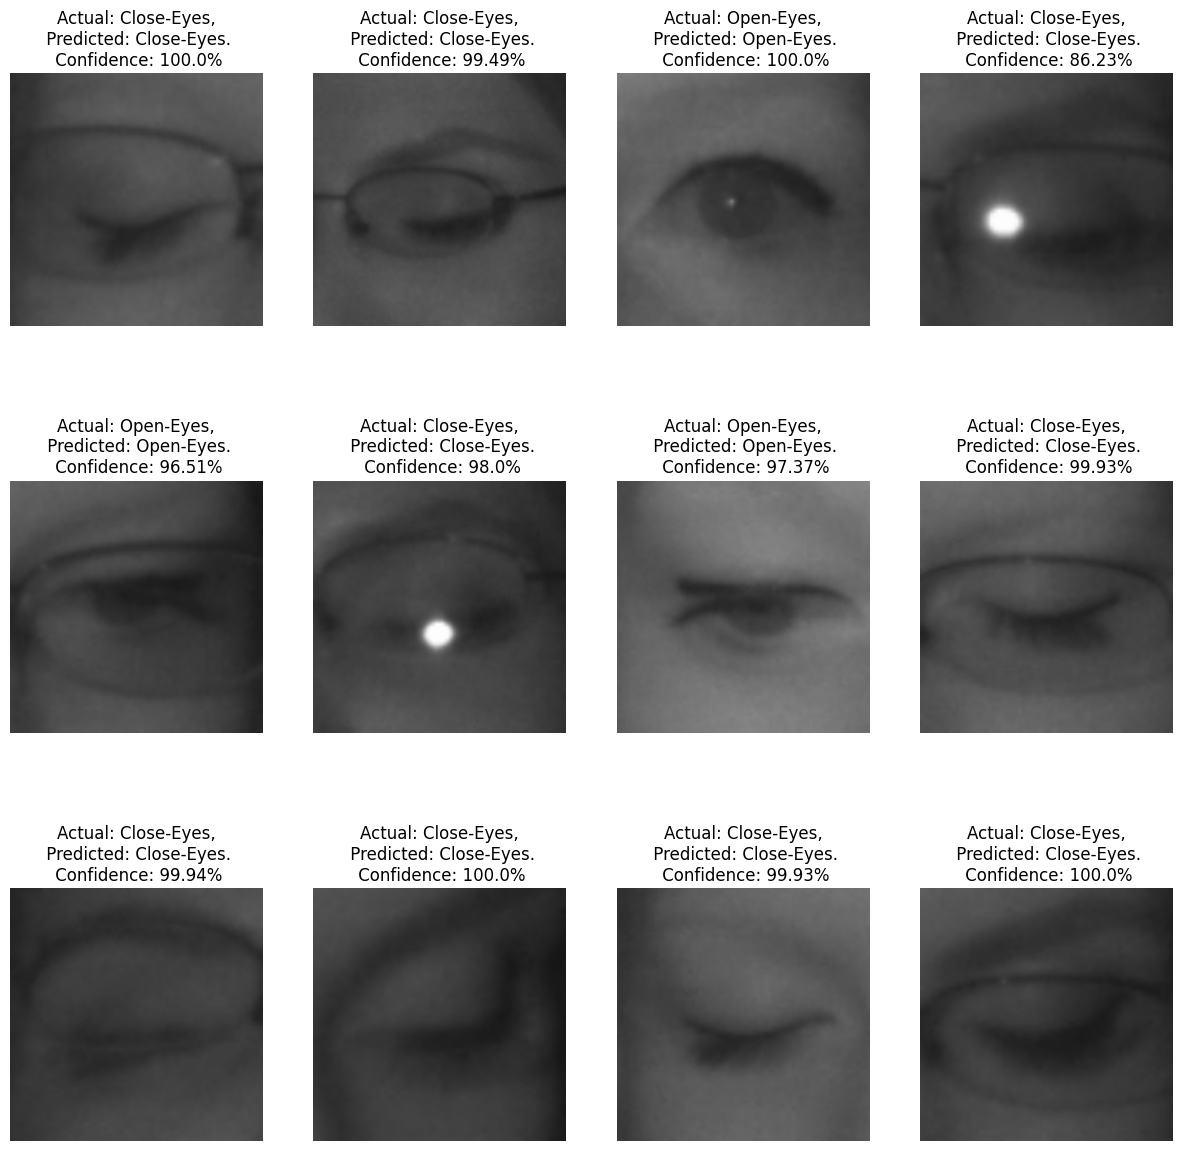

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

### Load the model

In [31]:
new_model = tf.keras.models.load_model('models/MyModel1.h5')

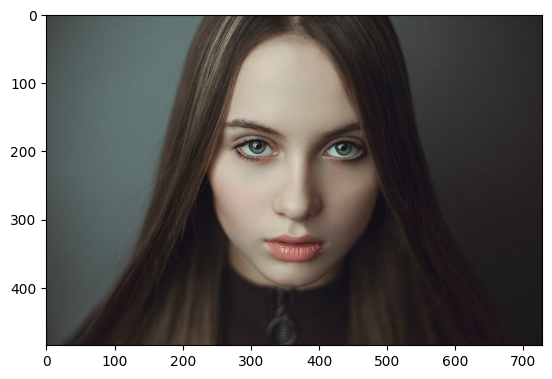

In [87]:
img = cv2.imread("women-face-portrait-simple-background-wallpaper-preview.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [88]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [89]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

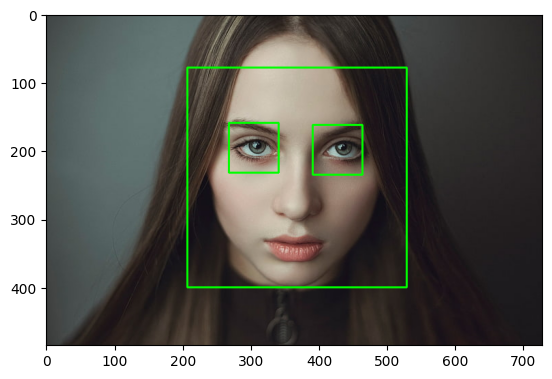

In [90]:
eyes = eye_cascade.detectMultiScale(gray,1.1,4)

faces = faceCascade.detectMultiScale(img,1.1,5)

for(x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

for(x,y,w,h) in eyes:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

### Cropping the Eye image

(55, 55, 3)

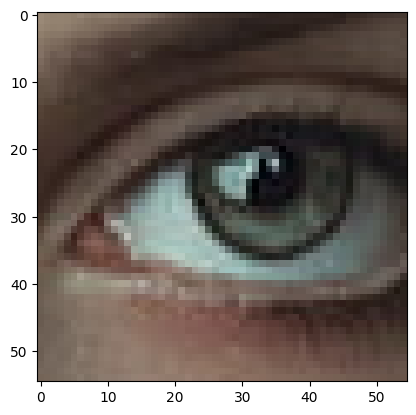

In [91]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
eyes = eye_cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = img[y:y+h,x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

plt.imshow(cv2.cvtColor(eyes_roi,cv2.COLOR_BGR2RGB))

eyes_roi.shape

In [92]:
final_image = cv2.resize(eyes_roi,(IMAGE_SIZE,IMAGE_SIZE))
final_image = np.expand_dims(final_image,axis=0) ##need fourth dimension
final_image = final_image/255.0

final_image.shape

(1, 224, 224, 3)

In [96]:
predictions = new_model.predict(final_image)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)
print(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")

Predicted: Open-Eyes.
 Confidence: 100.0%
